In [1]:
import numpy as np
from scipy.stats import lognorm
import matplotlib.pyplot as plt

# import plotly.express as px
# import plotly.graph_objects as go

In [2]:
from experiments import run_experiments

# The Data
## Log-Normal Distribution
In order to simulate an annoying real-world distribution, I used the log-normal distribution and rounded the results

This causes a large number of uniques, but with heavy-hitters and several lower probability uniques that still show up several times

## Sample Random Seed
To generate the same sample on several runs, I just used my id as the random seed.

## Sample size
I choose to use 200,000 (2e5) samples, since it's a nice round number.


In [3]:
X = lognorm.rvs(5, size=int(2e5), random_state=206783441).astype(int)

## Number of unique values
With the chosen seed I got 12147 unique values - which matches the criteria of 10k uniques

In [4]:
np.unique(X).shape

(12147,)

## How the distributions looks
We can see what I mean - many heavy hitters close to 0, but plenty of uniques

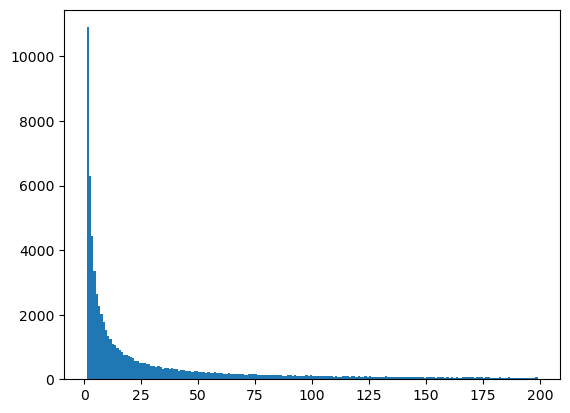

In [5]:
plt.hist(X, bins=np.arange(1, 200))
plt.show()

# Experiments
## Parameters
I ran 100 different experiments for each estimator and config, with the seeds being the values 1 to 100 for each one.

I used the seed to init the random hash function (the way it works is further elaborated in the file `experiments.py`) and besides that everthing else is deterministic

## Single $\alpha$ estimator
Here 200 experiments with a single $\alpha$ estimator - the larger amount of experiments is because the variance of $\alpha$ estimators is really high

In [6]:
alpha_results = run_experiments(X, base_seeds=np.arange(1, 201).tolist(), num_hashes=1, num_betas=1, num_procs=8)

num_hashes=1, num_betas=1: 100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


### The results
We can already see that median is really far from the actual value (around twice!)

In [7]:
np.median(alpha_results)

np.float64(19984.78935506544)

The mean is even worse, most likely due to outliers (as we'll see later)

In [8]:
np.mean(alpha_results)

np.float64(77956.14219632144)

The normalized variance is also insane - it's more than 53 million

In [9]:
np.var(alpha_results) / len(np.unique(X))

np.float64(3035365.7503246637)

when we plot a histogram of the values with the actual number of uniques, the mean, and the median - we can see that they are not even close!

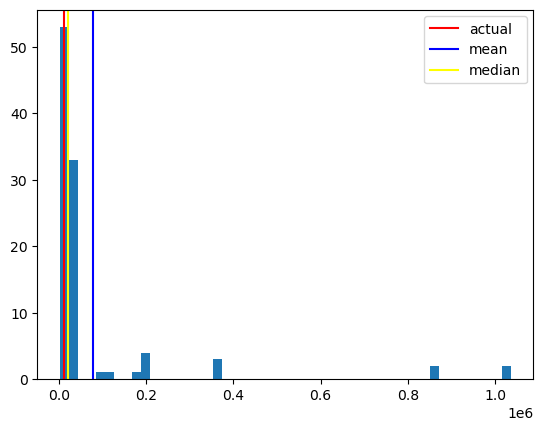

In [10]:
plt.hist(alpha_results, bins=50)
plt.axvline(x=len(np.unique(X)), color='red', label='actual')
plt.axvline(x=np.mean(alpha_results), color='blue', label='mean')
plt.axvline(x=np.median(alpha_results), color='yellow', label='median')
plt.legend()
plt.show()

If we zoom in a bit, we can see that the median has most values around it, while the actual value is the **32nd percentile!**

In [11]:
np.mean(np.array(alpha_results) <= len(np.unique(X)))

np.float64(0.32)

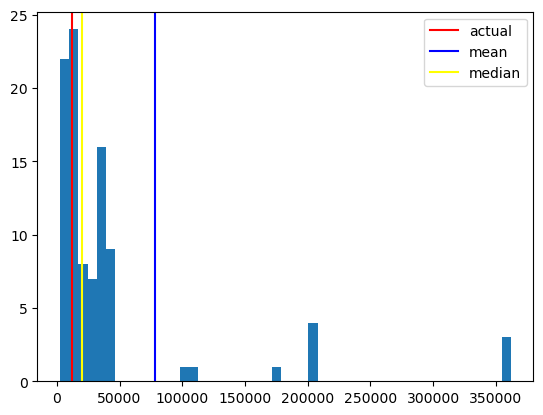

In [12]:
bins = np.linspace(np.min(alpha_results), np.percentile(alpha_results, 95), 50).tolist()
plt.hist(alpha_results, bins=sorted(bins))
plt.axvline(x=len(np.unique(X)), color='red', label='actual')
plt.axvline(x=np.mean(alpha_results), color='blue', label='mean')
plt.axvline(x=np.median(alpha_results), color='yellow', label='median')
plt.legend()
plt.show()

this shows that as we learned at class, the $\alpha$ estimator has way too much variance to be used as is

## Single $\beta$ estimator
Here I ran a full FM estimator with a several hash functions and a single $\beta$ estimator - which is just a $\beta$ estimator

### Evaluated sketch sizes
For the beta estimator, I ran the same number of experiments with the following sketch sizes: $k = [10, 50, 100, 500, 1000]$

In [65]:
beta_sketch_sizes = [25, 50, 100, 250, 500, 1000]

### Other Parameters
Due to the computation times, here I just ran 50 experiments for each sketch size - for the larger sketch sizes it took quite a while

In [14]:
raise Exception()

Exception: 

In [ ]:
beta_results = {
    sketch_size: run_experiments(X, base_seeds=np.arange(1, 101).tolist(), num_hashes=sketch_size, num_betas=1, num_procs=8)
    for sketch_size in beta_sketch_sizes
}

num_hashes=10, num_betas=1:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
beta_results.update({
    sketch_size: run_experiments(X, base_seeds=np.arange(1, 101).tolist(), num_hashes=sketch_size, num_betas=1, num_procs=8)
    for sketch_size in beta_sketch_sizes if sketch_size not in beta_results
})

In [15]:
import pickle
from pathlib import Path

beta_results = dict()
for pkl_file in Path().glob("results_b_1_h_*.pkl"):
    num_hashes = int(pkl_file.name.split('.')[0].split('_')[-1])
    with pkl_file.open('rb') as f:
        beta_results[num_hashes] = pickle.load(f)

In [54]:
beta_25 = run_experiments(X, base_seeds=np.arange(1, 101).tolist(), num_hashes=25, num_betas=1, num_procs=8)
print(f'median={float(np.median(beta_25))}')
print(f'mean={float(np.mean(beta_25))}')
f'norm_var={float(np.var(beta_25) / len(np.unique(X)))}'

num_hashes=25, num_betas=1: 100%|██████████| 100/100 [05:00<00:00,  3.00s/it]


median=13990.025223081395
mean=15015.215555138571


'norm_var=2689.757200206871'

In [55]:
beta_results[25] = beta_25

In [39]:
[f'{n_hashes=}: median={float(np.median(b_res))}, diff={abs(float(np.median(b_res)) - len(np.unique(X)))}' for n_hashes, b_res in sorted(beta_results.items())]

['n_hashes=10: median=16311.115040220884, diff=4164.115040220884',
 'n_hashes=50: median=12652.000194560955, diff=505.0001945609547',
 'n_hashes=100: median=12504.31011446371, diff=357.3101144637094',
 'n_hashes=1000: median=12141.74370431482, diff=5.2562956851797935']

In [40]:
[f'{n_hashes=}: mean={float(np.mean(b_res))}, diff={abs(float(np.mean(b_res)) - len(np.unique(X)))}' for n_hashes, b_res in sorted(beta_results.items())]

['n_hashes=10: mean=19840.806294874666, diff=7693.8062948746665',
 'n_hashes=50: mean=13615.713856871513, diff=1468.7138568715127',
 'n_hashes=100: mean=13139.923475349236, diff=992.9234753492365',
 'n_hashes=1000: mean=12251.484882724399, diff=104.48488272439863']

In [41]:
[f'{n_hashes=}: norm_var={float(np.var(b_res) / len(np.unique(X)))}' for n_hashes, b_res in sorted(beta_results.items())]

['n_hashes=10: norm_var=14464.27930082976',
 'n_hashes=50: norm_var=1169.2072687775824',
 'n_hashes=100: norm_var=617.6659405279678',
 'n_hashes=1000: norm_var=62.34363623429791']

### Histograms
By looking at the histograms with different numbers of $\alpha$ estimators, we can see how the variance trends lower and the mean gets closer to the actual number of unique elements.

With 1000 $\alpha$ estimators the difference between the median and the target is already visually indistinguishable, with the difference being only ~5.25.

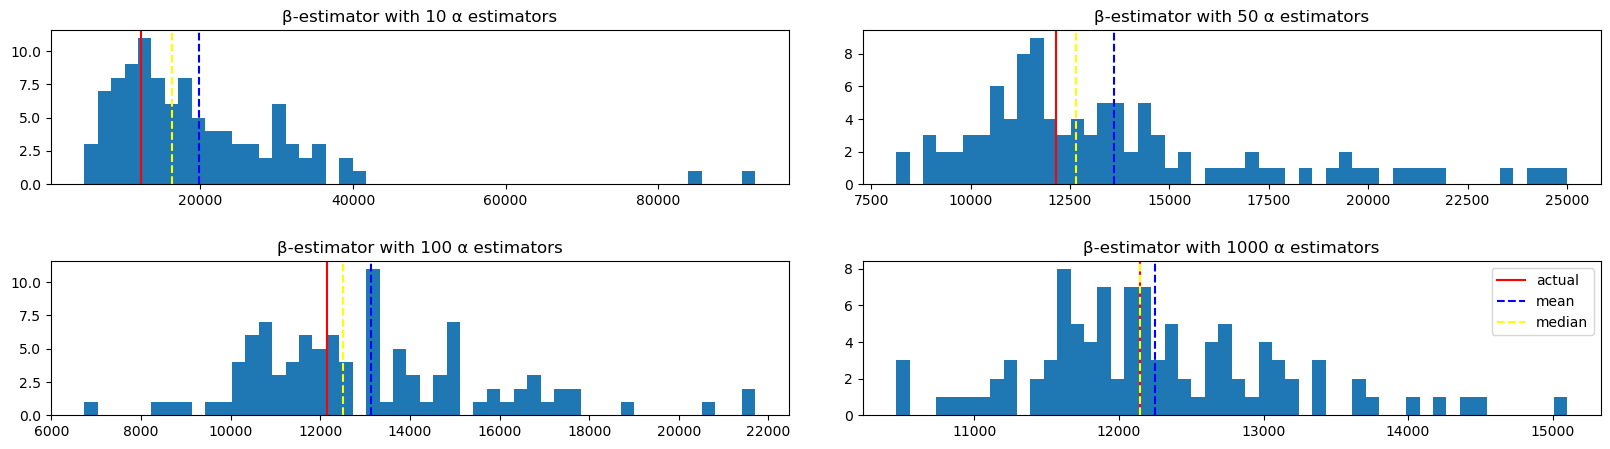

In [50]:
num_cols = int(np.sqrt(len(beta_results)))
num_rows = int(np.ceil(len(beta_results) / num_cols))
fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 5))
fig.subplots_adjust(wspace=0.1, hspace=0.5)
ax = ax.ravel()
for (n_hashes, b_res), cur_ax in zip(sorted(beta_results.items()), ax):
    cur_ax.hist(b_res, bins=50)
    cur_ax.axvline(x=len(np.unique(X)), color='red', label='actual')
    cur_ax.axvline(x=np.mean(b_res), color='blue', label='mean', linestyle='--')
    cur_ax.axvline(x=np.median(b_res), color='yellow', label='median', linestyle='--')
    cur_ax.set_title(f'β-estimator with {n_hashes} α estimators')
plt.legend()
plt.show()

### Mean as a function of the number of $\alpha$ estimators
We can see that the mean trends towards the actual value as the number of $\alpha$ estimators grows, which makes sense given what we learned in class

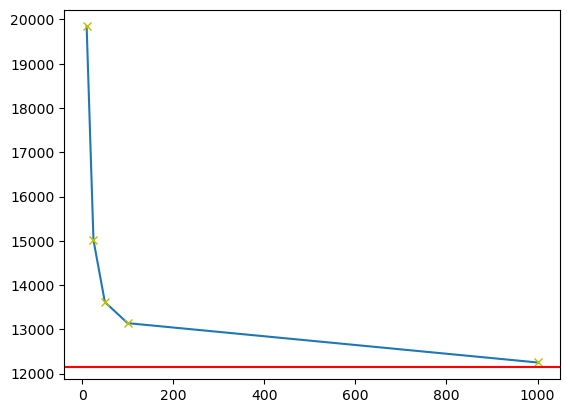

In [64]:
plt.plot(sorted(beta_results.keys()), [np.mean(beta_results[k]) for k in sorted(beta_results.keys())], marker='x', mec='y')
plt.axhline(y=len(np.unique(X)), color='red', label='actual')
plt.show()

### Median as a function of the number of $\alpha$ estimators
The median also trends towards the actual value as the number of $\alpha$ estimators grows, which is more interesting since this shows us what we could reasonably expect with the full FM estimator with 100 $\beta$ estimators

In [1]:
plt.plot(sorted(beta_results.keys()), [np.median(beta_results[k]) for k in sorted(beta_results.keys())], marker='x', mec='y')
plt.axhline(y=len(np.unique(X)), color='red', label='actual')
plt.show()

NameError: name 'plt' is not defined

### Normalized Variance as a function of the number of $\alpha$ estimators
The normalized variance seems to decrease linearly as a function of the number of $\alpha$ estimators, which matches what we learned in class

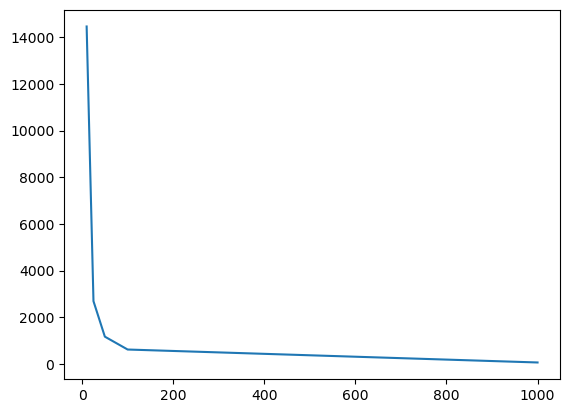

In [58]:
plt.plot(sorted(beta_results.keys()), [np.var(beta_results[k]) / len(np.unique(X)) for k in sorted(beta_results.keys())], marker='x', mec='y')
plt.show()

In [24]:
{k: np.var(val) / len(np.unique(X)) for k, val in beta_results.items()}

{10: np.float64(1500.9623883238824),
 50: np.float64(276.46580835131874),
 100: np.float64(144.13201480550518),
 500: np.float64(21.784362807996274),
 1000: np.float64(9.623186392562172)}

In [33]:
np.mean(np.array(tmp_results) <= len(np.unique(X)))

np.float64(0.06)

## Full full estimator
Here I ran a full FM estimator with 100 experiments with the following params:

| $\beta$-estimators | Hash Functions |
|--------------------|----------------|
| 4                  | 50             |
| 4                  | 100            |
| 4                  | 500            |
| 4                  | 1000           |
| 8                  | 100            |
| 8                  | 500            |
| 8                  | 1000           |